In [46]:
from __future__ import print_function, division
import os
import torch
from torch.utils.data import Dataset, DataLoader
import PIL
import torch.nn as nn
import torchvision
from utils.processing import *
from utils.vnfood_ds import *
from utils.trainer import *

In [47]:
import torch, sys
print("Python:", sys.version)
print("Torch:", torch.__version__, "| CUDA build:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    x = torch.rand(20000, 20000, device='cuda')
    y = x @ x
    torch.cuda.synchronize()
    print("GPU matmul OK")

Python: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
Torch: 2.5.1+cu121 | CUDA build: 12.1
CUDA available: True
GPU: Quadro RTX 5000
GPU matmul OK


In [48]:
# ==== Đường dẫn dữ liệu ====
ROOT = "C:/TRAIN/Deep Learning/vietnamese-foods/Images"   # <== đổi nếu cần
root_train = f"{ROOT}/Train"
root_val   = f"{ROOT}/Validate"
root_test  = f"{ROOT}/Test"

Name_food = {0: 'Banh beo',
 1:'Banh bot loc',
 2:'Banh can',
 3:'Banh canh',
 4:'Banh chung',
 5:'Banh cuon',
 6:'Banh duc',
 7:'Banh gio',
 8:'Banh khot',
 9:'Banh mi',
 10:'Banh pia',
 11:'Banh tet',
 12:'Banh trang nuong',
 13:'Banh xeo',
 14:'Bun bo Hue',
 15:'Bun dau mam tom',
 16:'Bun mam',
 17:'Bun rieu',
 18:'Bun thit nuong',
 19:'Ca kho to',
 20:'Canh chua',
 21:'Cao lau',
 22:'Chao long',
 23:'Com tam',
 24:'Goi cuon',
 25:'Hu tieu',
 26:'Mi quang',
 27:'Nem chua',
 28:'Pho',
 29:'Xoi xeo', 
30:'banh_da_lon',
31:'banh_tieu',
32:'banh_trung_thu' 
}

In [49]:
train_paths, train_labels, val_paths, val_labels, test_paths, test_labels = getAllDataset()

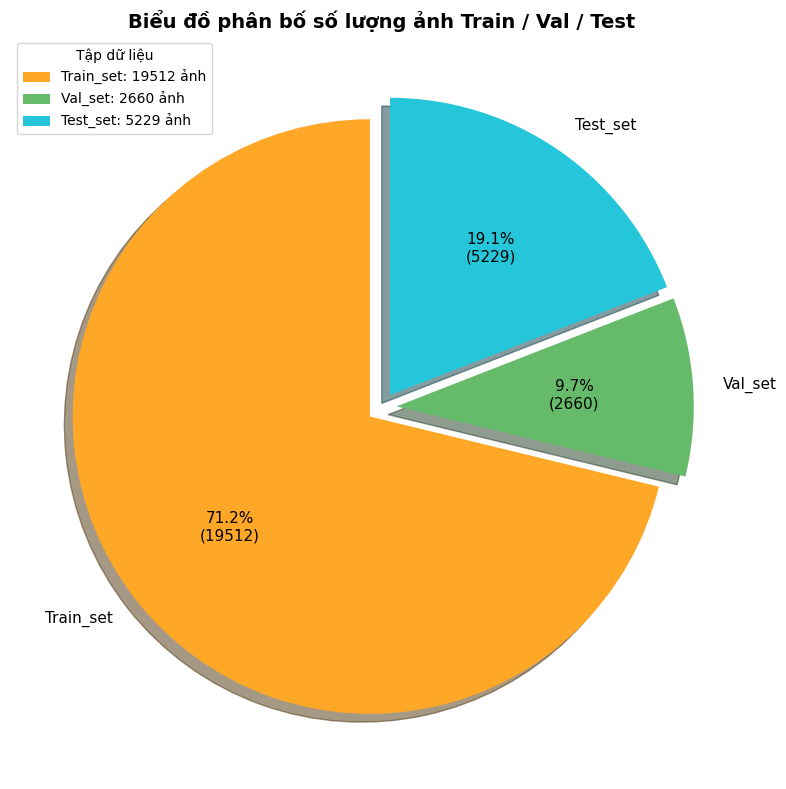

In [50]:
import matplotlib.pyplot as plt

# Giả sử bạn đã có các biến sau:
# train_paths, val_paths, test_paths = ...
data = {
    "Train_set": len(train_paths),
    "Val_set": len(val_paths),
    "Test_set": len(test_paths)
}

# Màu & hiệu ứng tách lát
colors = ['#FFA726', '#66BB6A', '#26C6DA']
explode = (0.05, 0.05, 0.05)

# Tổng ảnh
total_images = sum(data.values())

# Hàm hiển thị số lượng và %
def autopct_with_count(pct):
    total = total_images
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"  # hiển thị 2 dòng

# Vẽ biểu đồ
plt.figure(figsize=(8, 8))

wedges, texts, autotexts = plt.pie(
    data.values(),
    labels=data.keys(),
    autopct=autopct_with_count,
    colors=colors,
    explode=explode,
    shadow=True,
    startangle=90,
    textprops=dict(color="black", fontsize=11)
)

# Thêm tiêu đề và chú thích
plt.title("Biểu đồ phân bố số lượng ảnh Train / Val / Test", fontsize=14, fontweight='bold')
plt.legend(
    wedges,
    [f"{k}: {v} ảnh" for k, v in data.items()],
    title="Tập dữ liệu",
    loc="best"
)
plt.tight_layout()
plt.show()

In [51]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_labels = lb.fit_transform(train_labels)
val_labels = lb.fit_transform(val_labels)
test_labels = lb.fit_transform(test_labels)

In [52]:
train_labels = np.eye(33)[train_labels]
val_labels = np.eye(33)[val_labels]
test_labels = np.eye(33)[test_labels]
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} images)".format(pct, absolute)

In [53]:
import pandas as pd
def plot_compare_distributions(array1, array2, array3, food_name, title1='Train images distribution', title2='', title3 = '' ):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array3 = pd.DataFrame()
    df_array1['food_name'] = array1.argmax(axis=1)
    df_array2['food_name'] = array2.argmax(axis=1)
    df_array3['food_name'] = array3.argmax(axis=1)
    highlight =(0.05,0.05,0.05, 0.05)
    fig, axs = plt.subplots(1, 3, figsize=(20, 12), sharey=False)
    x = food_name.values()
    colors = ['orange', 'green', 'cyan', "red"]

    y = df_array1['food_name'].value_counts()
    keys_missed = list(set(food_name.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].pie(y, explode=highlight, labels=x, colors=colors, autopct=lambda pct: func(pct, y), shadow=True)
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['food_name'].value_counts()
    keys_missed = list(set(food_name.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].pie(y, explode=highlight, labels=x, colors=colors, autopct=lambda pct: func(pct, y), shadow=True)
    axs[1].set_title(title2)
    axs[1].grid()
    
    y = df_array3['food_name'].value_counts()
    keys_missed = list(set(food_name.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[2].pie(y, explode=highlight, labels=x, colors=colors, autopct=lambda pct: func(pct, y), shadow=True)
    axs[2].set_title(title3)
    axs[2].grid()
    plt.show()

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

def _counts_from_logits(arr, n_classes: int):
    """arr: (N, C) logits/probs hoặc (N,) labels int.
       Trả về Series độ dài C, đủ mọi lớp (fill 0 nếu thiếu)."""
    if arr.ndim == 2:  # (N, C) -> lấy argmax
        labels = arr.argmax(axis=1)
    else:              # (N,) đã là label
        labels = arr
    s = pd.Series(labels).value_counts().sort_index()
    return s.reindex(range(n_classes), fill_value=0)

def _names_from_mapping(name_food: dict):
    """Trả về list tên lớp theo thứ tự id tăng dần."""
    return [name for name, idx in sorted(name_food.items(), key=lambda kv: kv[1])]

def _autopct(values):
    total = float(values.sum())
    def fmt(pct):
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val})'
    return fmt

def plot_compare_distributions(array1, array2, array3, name_food: dict,
                               title1='Phân phối dữ liệu tập huấn luyện',
                               title2='Phân phối dữ liệu tập đánh giá',
                               title3='Phân phối dữ liệu tập kiểm tra'):
    n_classes = len(name_food)
    labels = _names_from_mapping(name_food)

    # Đếm từng split
    import numpy as np  # thêm trên đầu file

    y1 = _counts_from_logits(np.asarray(array1), n_classes)
    y2 = _counts_from_logits(np.asarray(array2), n_classes)
    y3 = _counts_from_logits(np.asarray(array3), n_classes)

    # explode & colors khớp số lớp
    explode = [0.05] * n_classes
    # Ghép nhiều bảng màu cho đủ 30+ màu
    palette = list(plt.cm.tab20.colors) + list(plt.cm.tab20b.colors) + list(plt.cm.tab20c.colors)
    colors = palette[:n_classes]

    fig, axs = plt.subplots(1, 3, figsize=(20, 12), sharey=False)

    axs[0].pie(y1.values, explode=explode, labels=labels, colors=colors,
               autopct=_autopct(y1.values), shadow=True)
    axs[0].set_title(title1); axs[0].grid()

    axs[1].pie(y2.values, explode=explode, labels=labels, colors=colors,
               autopct=_autopct(y2.values), shadow=True)
    axs[1].set_title(title2); axs[1].grid()

    axs[2].pie(y3.values, explode=explode, labels=labels, colors=colors,
               autopct=_autopct(y3.values), shadow=True)
    axs[2].set_title(title3); axs[2].grid()

    plt.tight_layout()
    plt.show()

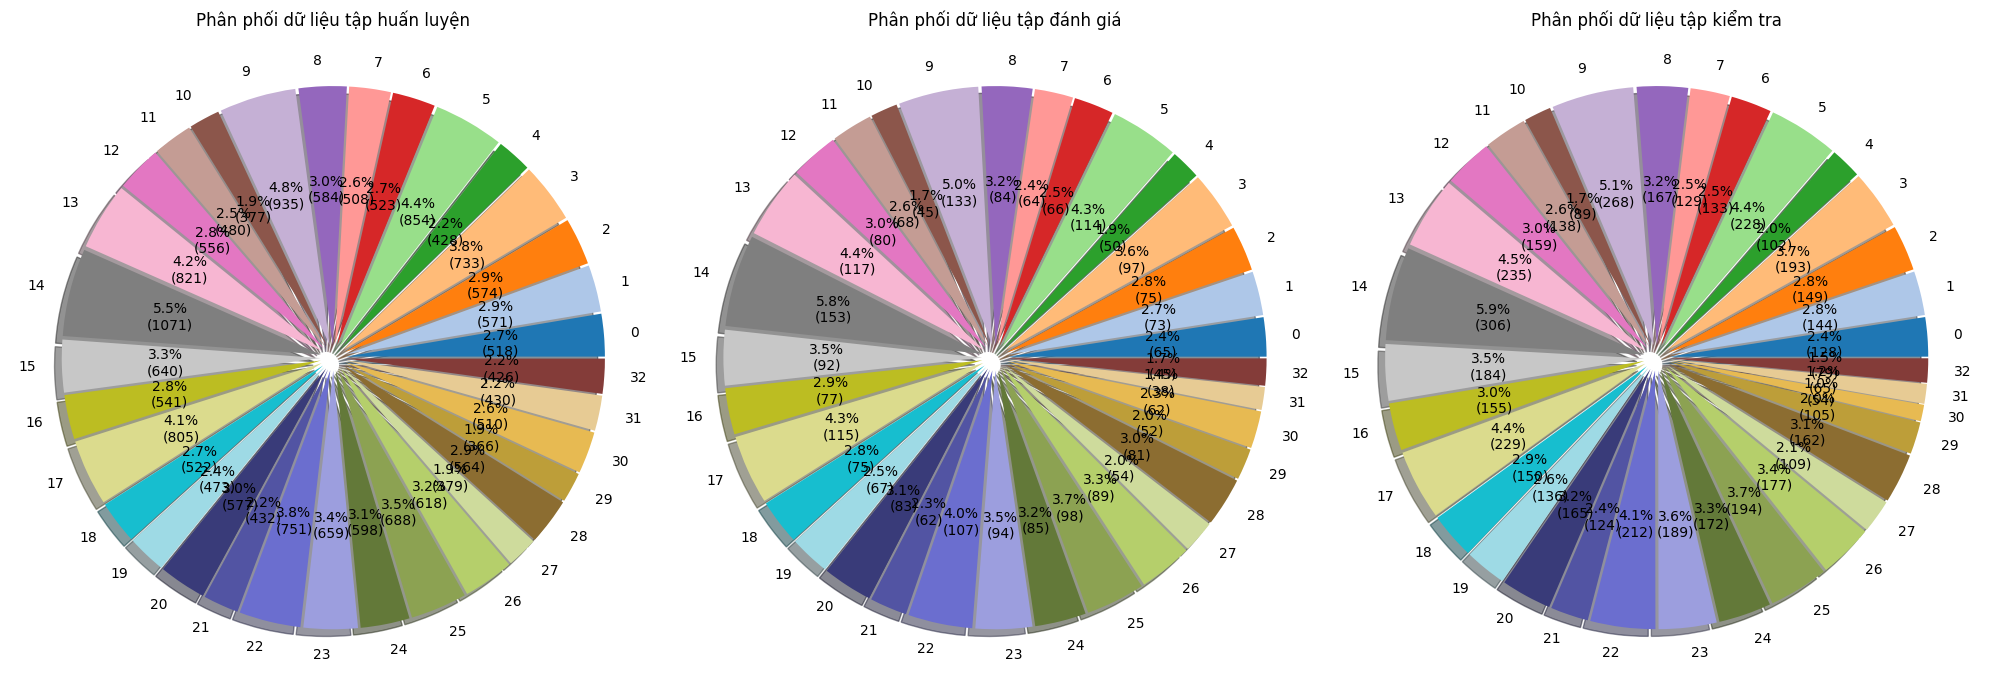

In [55]:
plot_compare_distributions(train_labels, val_labels, test_labels, Name_food)

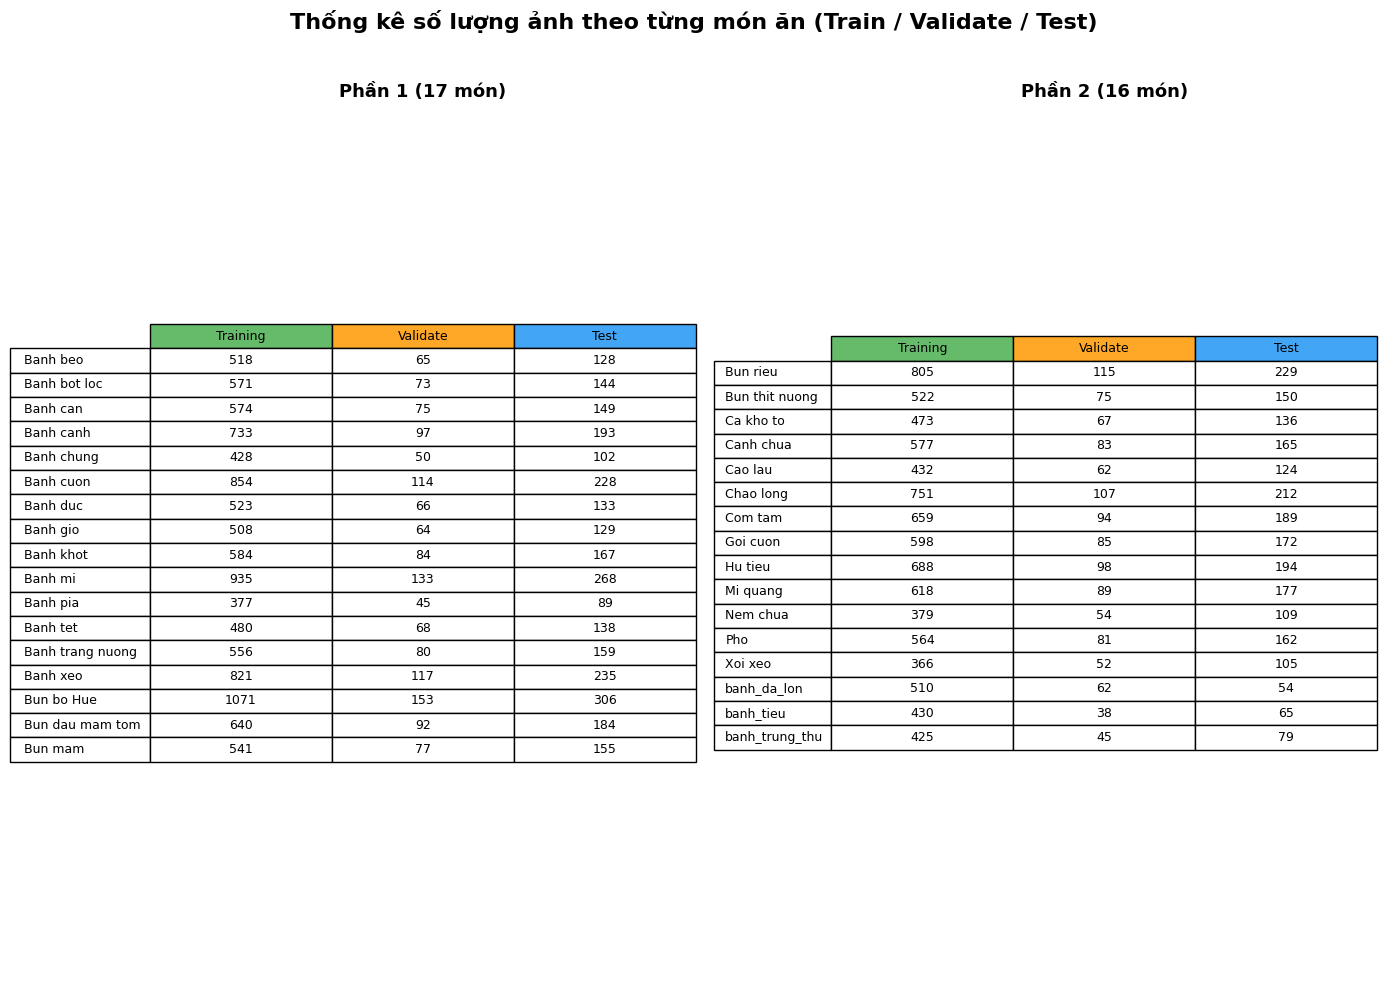

✅ Đã lưu hình bảng tại: ./images\dataset_table_2cols.png


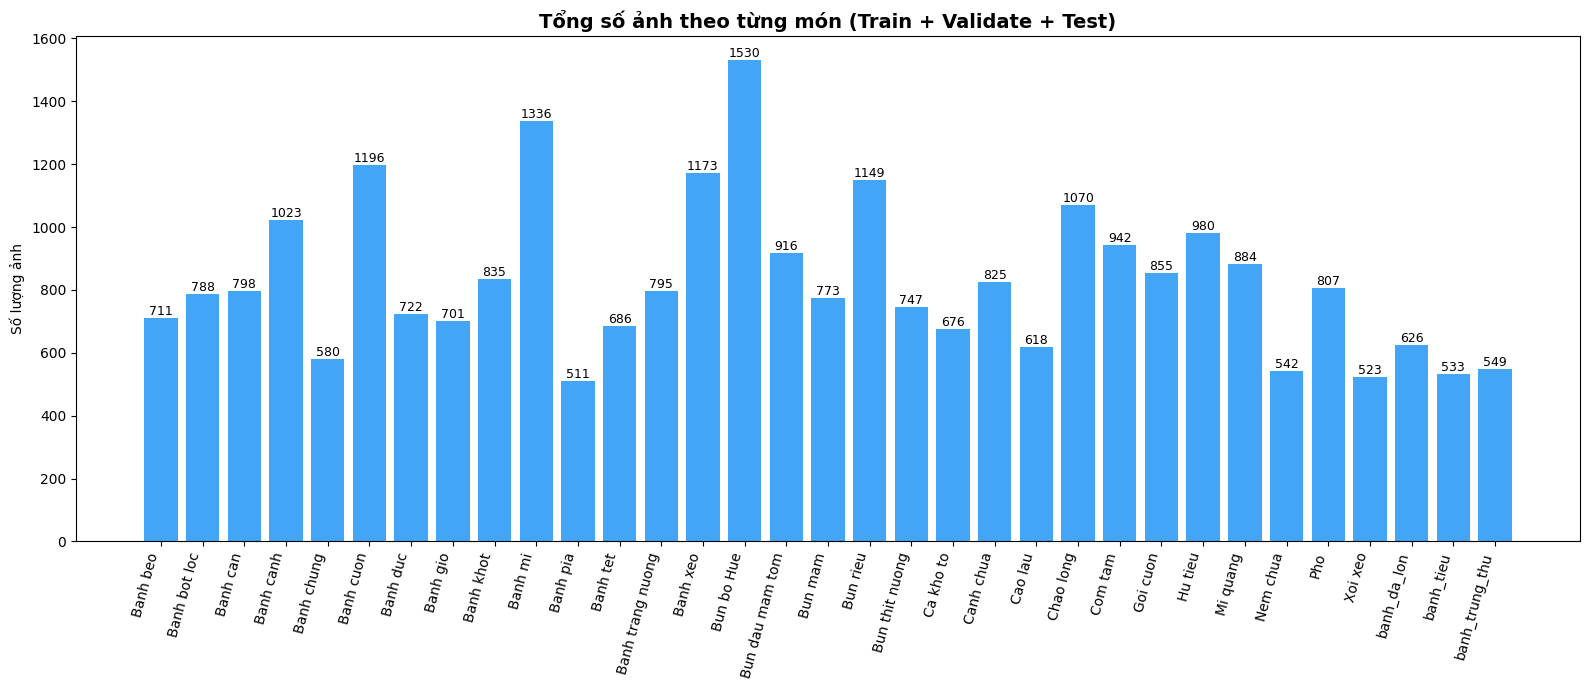

✅ Đã lưu hình biểu đồ tại: ./images\class_distribution_bar.png

📌 Tổng kết:
  - Tổng số lớp     : 33
  - Tổng ảnh Train   : 19511
  - Tổng ảnh Validate: 2660
  - Tổng ảnh Test    : 5229


In [56]:
# %% Đếm ảnh và hiển thị bảng thống kê Train / Validate / Test
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ==== Đường dẫn dữ liệu ====
ROOT = "C:/TRAIN/Deep Learning/vietnamese-foods/Images"   # <== đổi nếu cần
root_train = f"{ROOT}/Train"
root_val   = f"{ROOT}/Validate"
root_test  = f"{ROOT}/Test"

SAVE_DIR = "./images"
os.makedirs(SAVE_DIR, exist_ok=True)

# ==== Hàm đếm số lượng ảnh trong từng lớp ====
def count_images_by_class(folder):
    exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
    counts = {}
    if not os.path.exists(folder):
        print(f"⚠️ Không tìm thấy thư mục: {folder}")
        return counts
    for cls in sorted(os.listdir(folder)):
        path = os.path.join(folder, cls)
        if os.path.isdir(path):
            n = len([f for f in os.listdir(path) if f.lower().endswith(exts)])
            counts[cls] = n
    return counts

train_counts = count_images_by_class(root_train)
val_counts   = count_images_by_class(root_val)
test_counts  = count_images_by_class(root_test)

# ==== Gộp danh sách lớp ====
all_classes = sorted(set(train_counts) | set(val_counts) | set(test_counts))
df = pd.DataFrame({
    "Training": [train_counts.get(c, 0) for c in all_classes],
    "Validate": [val_counts.get(c, 0) for c in all_classes],
    "Test": [test_counts.get(c, 0) for c in all_classes],
}, index=all_classes)

# ==== Kiểm tra lớp thiếu ảnh ở tập nào ====
for c in all_classes:
    missing = []
    if df.loc[c, "Training"] == 0: missing.append("Train")
    if df.loc[c, "Validate"] == 0: missing.append("Val")
    if df.loc[c, "Test"] == 0: missing.append("Test")
    if missing:
        print(f"⚠️ Lớp {c} thiếu ảnh ở: {', '.join(missing)}")

# ==== Chia bảng thành 2 phần (17 và 16 lớp) ====
left_df  = df.iloc[:17]
right_df = df.iloc[17:]

# ==== Hiển thị bảng thống kê ====
fig, axes = plt.subplots(1, 2, figsize=(14, 10))
fig.suptitle("Thống kê số lượng ảnh theo từng món ăn (Train / Validate / Test)", fontsize=16, fontweight='bold')

def draw_table(ax, sub_df, title):
    ax.axis("off")
    tbl = ax.table(
        cellText=sub_df.values,
        colLabels=sub_df.columns,
        rowLabels=sub_df.index,
        loc="center",
        cellLoc="center",
        colColours=["#66BB6A", "#FFA726", "#42A5F5"]
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.15, 1.3)
    ax.set_title(title, fontsize=13, pad=10, fontweight="bold")

draw_table(axes[0], left_df,  f"Phần 1 ({len(left_df)} món)")
draw_table(axes[1], right_df, f"Phần 2 ({len(right_df)} món)")
plt.tight_layout(rect=[0, 0, 1, 0.96])

save_path_table = os.path.join(SAVE_DIR, "dataset_table_2cols.png")
plt.savefig(save_path_table, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
print(f"✅ Đã lưu hình bảng tại: {save_path_table}")

# ==== Biểu đồ cột tổng số ảnh ====
df["Total"] = df.sum(axis=1)
plt.figure(figsize=(16, 7))
bars = plt.bar(df.index, df["Total"], color="#42A5F5")
plt.title("Tổng số ảnh theo từng món (Train + Validate + Test)", fontsize=14, fontweight="bold")
plt.ylabel("Số lượng ảnh")
plt.xticks(rotation=75, ha="right")

for b in bars:
    v = int(b.get_height())
    if v > 0:
        plt.text(b.get_x() + b.get_width()/2, v, str(v), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
save_path_bar = os.path.join(SAVE_DIR, "class_distribution_bar.png")
plt.savefig(save_path_bar, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
print(f"✅ Đã lưu hình biểu đồ tại: {save_path_bar}")

# ==== Tổng kết ====
print("\n📌 Tổng kết:")
print(f"  - Tổng số lớp     : {len(df)}")
print(f"  - Tổng ảnh Train   : {int(df['Training'].sum())}")
print(f"  - Tổng ảnh Validate: {int(df['Validate'].sum())}")
print(f"  - Tổng ảnh Test    : {int(df['Test'].sum())}")
